In [39]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [27]:
device = torch.device("cuda")

使用$FashionMNIST$作为测试$Softmax$回归的数据集

In [28]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/test/Datasets/FashionMNIST',train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/test/Datasets/FashionMNIST',train=False, download=True, transform=transforms.ToTensor())

$MNIST$数据集

In [40]:
mnist_train = torchvision.datasets.MNIST(root='~/test/Datasets/MNIST',train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='~/test/Datasets/MNIST',train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/hatcher/test/Datasets/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /home/hatcher/test/Datasets/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/hatcher/test/Datasets/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /home/hatcher/test/Datasets/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/hatcher/test/Datasets/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/hatcher/test/Datasets/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/hatcher/test/Datasets/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/hatcher/test/Datasets/MNIST/MNIST/raw



In [41]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,shuffle=False, num_workers=2)

In [42]:
class My_SoftmaxNet(nn.Module):
    def __init__(self,num_inputs,num_outputs):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.w = nn.Parameter(torch.normal(0, 0.01, size=(self.num_inputs, self.num_outputs), requires_grad=True))
        self.b = nn.Parameter(torch.zeros(self.num_outputs, requires_grad=True))
        self.sigmoid = nn.Sigmoid()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def softmax(self,x):
        X_exp = torch.exp(x)
        partition = X_exp.sum(1, keepdim=True)
        return X_exp / partition  # 这里应用了广播机制
    
    def forward(self,x):
        initial_output = self.sigmoid(torch.mm(x.view(-1,self.num_inputs),self.w)+self.b)
        softmax_output = self.softmax(initial_output)
        return softmax_output

In [43]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

In [44]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

In [45]:
def train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b):
    train_loss=[]
    test_loss=[]
    train_accuracy=[]
    test_accuracy=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device) 
            y_hat = net(X)
            w,b = net.parameters()
            y_hat = y_hat.squeeze()
            l=loss(y_hat,y).sum()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        train_accuracy.append(train_acc_sum/n)
        test_accuracy.append(test_acc)
        print('epoch%d,loss%.4f,train acc %3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
    for params in net.parameters():
        print(params)
    return train_loss,test_loss,train_accuracy,test_accuracy

In [52]:
num_inputs = 784
num_outputs = 10
num_epochs = 50
lr = 0.0001
net = My_SoftmaxNet(num_inputs,num_outputs)
net.to(device)
#optimizer=optim.SGD(net.parameters(),lr)
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=0.03)
optimizer_b = optim.SGD(params=[net.b],lr=lr)
loss = cross_entropy

In [47]:
import matplotlib.pyplot as plt
import numpy as np
def visualization(train_loss,test_loss,train_accuracy,test_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,test_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,test_accuracy,label='test_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()    
    plt.show()

In [50]:
#wd = 0.03
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss2.1620,train acc 0.447850,test acc 0.714
epoch2,loss1.9809,train acc 0.751983,test acc 0.794
epoch3,loss1.8942,train acc 0.794883,test acc 0.817
epoch4,loss1.8445,train acc 0.811133,test acc 0.830
epoch5,loss1.8120,train acc 0.820500,test acc 0.836
epoch6,loss1.7887,train acc 0.827133,test acc 0.842
epoch7,loss1.7710,train acc 0.832233,test acc 0.846
epoch8,loss1.7569,train acc 0.835167,test acc 0.850
epoch9,loss1.7455,train acc 0.839167,test acc 0.853
epoch10,loss1.7358,train acc 0.841517,test acc 0.855
epoch11,loss1.7276,train acc 0.843667,test acc 0.857
epoch12,loss1.7204,train acc 0.845983,test acc 0.859
epoch13,loss1.7141,train acc 0.847900,test acc 0.860
epoch14,loss1.7085,train acc 0.849283,test acc 0.861
epoch15,loss1.7035,train acc 0.851050,test acc 0.862
epoch16,loss1.6990,train acc 0.852700,test acc 0.863
epoch17,loss1.6948,train acc 0.853867,test acc 0.865
epoch18,loss1.6910,train acc 0.855167,test acc 0.866
epoch19,loss1.6875,train acc 0.856383,test acc 0.867
ep

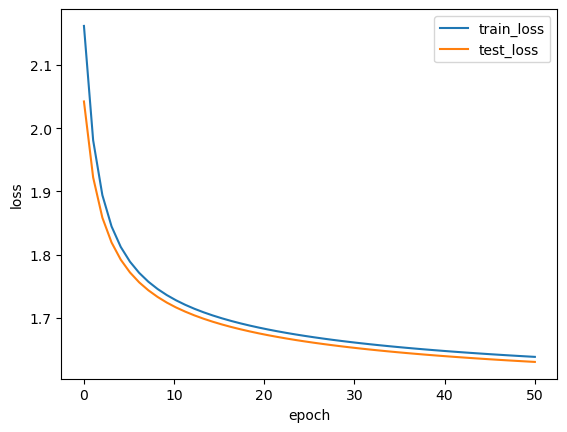

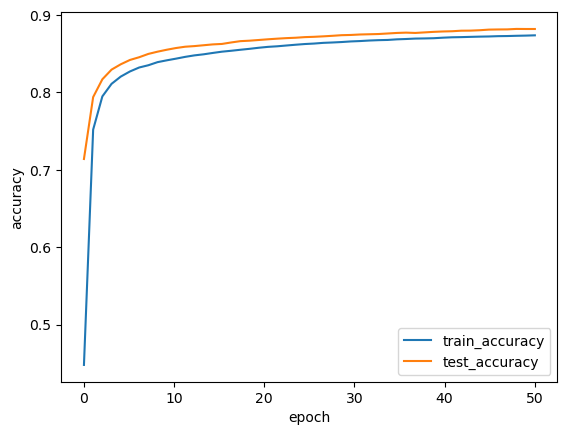

In [51]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)

In [53]:
lr = 0.0001
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=0)

In [54]:
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss2.1538,train acc 0.451967,test acc 0.700
epoch2,loss1.9767,train acc 0.738083,test acc 0.785
epoch3,loss1.8917,train acc 0.788117,test acc 0.811
epoch4,loss1.8427,train acc 0.807333,test acc 0.825
epoch5,loss1.8104,train acc 0.818150,test acc 0.832
epoch6,loss1.7872,train acc 0.825033,test acc 0.838
epoch7,loss1.7695,train acc 0.829867,test acc 0.844
epoch8,loss1.7555,train acc 0.834400,test acc 0.847
epoch9,loss1.7441,train acc 0.837833,test acc 0.849
epoch10,loss1.7344,train acc 0.840300,test acc 0.852
epoch11,loss1.7262,train acc 0.842850,test acc 0.854
epoch12,loss1.7191,train acc 0.845500,test acc 0.855
epoch13,loss1.7128,train acc 0.846917,test acc 0.858
epoch14,loss1.7072,train acc 0.848917,test acc 0.859
epoch15,loss1.7022,train acc 0.850533,test acc 0.861
epoch16,loss1.6976,train acc 0.852433,test acc 0.862
epoch17,loss1.6935,train acc 0.853667,test acc 0.862
epoch18,loss1.6897,train acc 0.855133,test acc 0.863
epoch19,loss1.6862,train acc 0.856050,test acc 0.864
ep

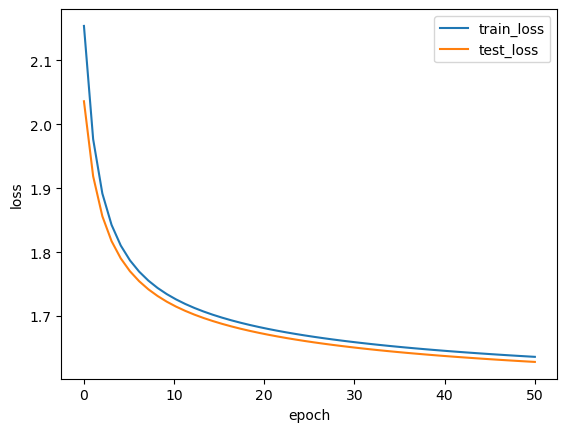

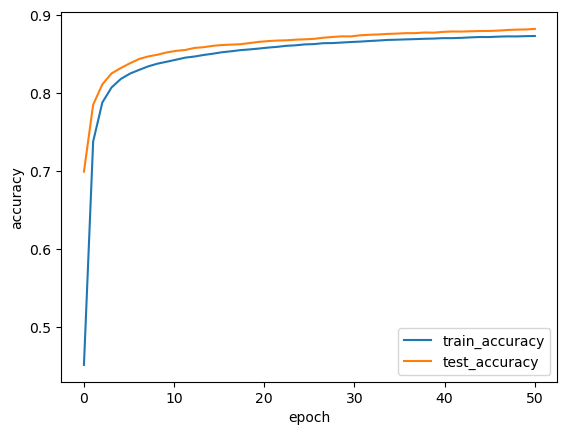

In [55]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)